In [1]:
from jax import jit, vmap, random
#import jax.numpy as np
import numpy as np
import pandas as pd
import datetime
import jax

# enable float 64
from jax.config import config

# config.update('jax_enable_x64', True)

# How to use the Iterated EAKF

## Define the your process model $f$, your observational model $g$ and the initial guess of the state space $f_0$ 
- See code below
- We use binomial transition between compartments such that the number of people transitioning from compartment X to compartment Y at rate $\tau$ will be:
$$N_{X\rightarrow Y} \sim \text{Binom}\left(X,  1-\exp\left(\tau\cdot \Delta t\right)\right)$$

Note that here $\tau$ could be a function of $Y$ (Force of Infection for example), and that the process model also account for the step size $\Delta t$. In general, the step size can be embedded in the parameters of the model, but as a good practice we keep in as an argument of the process model with defualt to one $\Delta t=1$.

In [2]:
# https://github.com/google/jax/issues/10144
def binomial_transition(xi, tau, dt=1):
    kb    = np.maximum(1.0 - np.exp(-tau*dt), 0)
    pop   = np.random.binomial(list(xi), kb )
    return pop

def checkpopvars(x, pop):
    return np.clip(x, 0, pop)

def f(t, x, beta, gamma, N=1e6, dt=1):
    S   = x[0, :]   # Susceptibles
    I   = x[1, :]   # Infected Reported
    R   = x[2, :]   # Recovered

    foi =  beta * (I) / N

    # Stochastic transitions
    s2i     =  binomial_transition(S, foi * dt)    # susceptible to exposed
    i2r     =  binomial_transition(I, gamma * dt) # exposed to infected reported who are not going to die

    # Updates
    S    = S   - s2i       # Susceptible
    I    = I   + s2i - i2r # Infected reported
    R    = R   + i2r       # Recovered
    C    = s2i

    return checkpopvars(np.array([S, I, R, C]), N)

def g(t, x, report_rate):
    """
    Observational model.
        Args:
            t: time
            x: state space
            θ: parameters
            ρ: report rate
    """
    y = np.random.binomial(list(x[3, :]), report_rate)
    return y

def f0(pop=1e6, inf_init=0.01, m=300):
    """
    Initial guess of the state space.
    """
    I0 = pop * inf_init
    S0 = pop - I0
    R0 = 0
    C0 = I0

    x0 = np.ones((4, m)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)
    return x0

## Simulate the model to have one stochastic trajectory for ingest in the Iterated EAKF.

In [3]:
R0    = 2.5
gamma = 1/4
beta  = R0*gamma
N     = 1e6

beta_truth        = beta
gamma_truth       = gamma
report_rate_truth = 0.3


T    = 70
dt   = 1
ens  = 500
x0    = f0(N, 0.1, m=ens)
x_sim = x0

x_sim          = np.full((4, T, ens), np.nan)
x_sim[:, 0, :] = x0

for t in range(1, T):
    x_sim[:, t, :]  = f(t, x_sim[:, t-1, :], beta_truth, gamma_truth, N, dt=dt)
C =  np.random.binomial(list(x_sim[3, :, :]), report_rate_truth)

obs_use   = C[:, np.random.randint(ens)]
obs_use_n = obs_use# + np.squeeze(jax.random.normal(k, shape=(T, 1))*0.5), 0)


In [4]:
observation_df          = pd.DataFrame(obs_use_n, columns=['y1'])
observation_df["oev1"]  = np.maximum(20, 1 +( 0.2 * observation_df["y1"].values)**2)
observation_df["date"] = pd.date_range(start=datetime.datetime(2020, 1, 1), periods=T, freq='D')


In [18]:
from ifeakf import ifeakf



model_settings = {
    "m"           : 500,                                         # number of ensembles
    "p"           : 3,                                           # number of parameters
    "k"           : 1,                                           # number of observations
    "n"           : 4,                                           # number of state variables / dimension of the state space
    "dt"          : 1,                                           # time step
    "param_name"  : ["β", "γ", "ρ"],                             # name of the parameters
    "dates"       : observation_df["date"].values,               # integration dates (for the process model) | date_{t+1}-date_t = dt
    "param_truth" : [beta_truth, gamma_truth, report_rate_truth] # true parameter values (not required - just for the example)
    }

if_settings = {
   "Nif"                : 40,                           # number of iterations of the IF
   "type_cooling"       : "geometric",                  # type of cooling schedule
   "shrinkage_factor"   : 0.9,                          # shrinkage factor for the cooling schedule
   "inflation"          : 1.01,                         # inflation factor for spreading the variance after the EAKF step
   "assimilation_dates" : observation_df["date"].values # assimilation dates (for the inference)
}

N     = 1e6


# Function to be used for the ikeafk function.
f_if  = lambda t, x, θ: f(t, x, θ[0, :], θ[1, :], N)
g_if  = lambda t, x, θ: g(t, x, θ[2, :])
f0_if = lambda θ: f0(pop=N, inf_init=10/100, m=model_settings["m"])


γmin = 1/15
γmax = 1/3

βmin = 0.2
βmax = 3.5

ρmin = 0.01
ρmax = 1

state_space_range = np.array([0, N])
parameters_range  = np.array([[βmin, βmax],
                              [γmin, γmax],
                              [ρmin, ρmax]])

σ_perturb = np.array([(βmax-βmin) / 2, (γmax-γmin) / 2, (γmax-γmin) / 2])


In [19]:
obs_df                  = observation_df.set_index("date")#.resample("W-Sun").sum()
obs_df.index.values[-1] = model_settings["dates"][-1]
obs_df["oev1"]  = np.maximum(20, 1 +( 0.2 * obs_df["y1"].values)**2)

if_settings["assimilation_dates"] = obs_df.index.values

θmle, θpost = ifeakf(process_model            = f_if,
                    observational_model       = g_if,
                    state_space_initial_guess = f0_if,
                    observations_df           = obs_df,            #resample so assimilitation dates are weekly
                    parameters_range          = parameters_range,
                    state_space_range         = state_space_range,
                    model_settings            = model_settings,
                    if_settings               = if_settings,
                    perturbation              = σ_perturb)


100%|██████████| 40/40 [00:11<00:00,  3.48it/s]


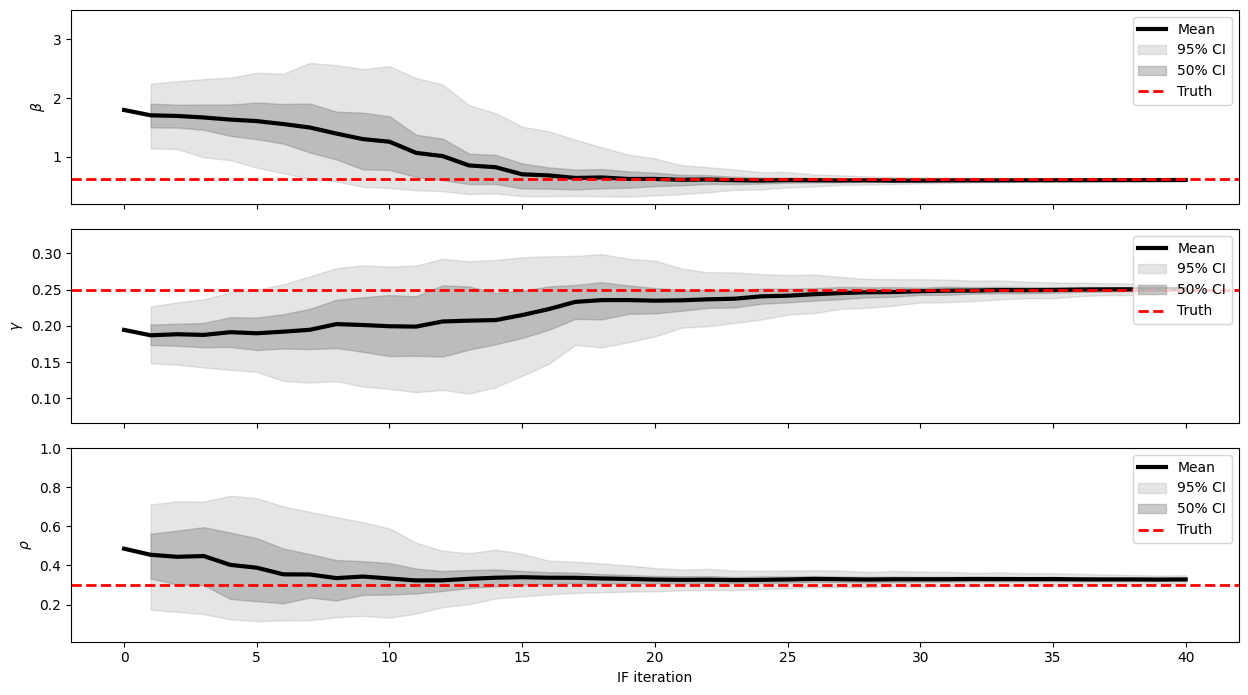

In [20]:
from diagnostic_plots import convergence_plot
from utils import create_df_response
import matplotlib.pyplot as plt

p_truth = model_settings["param_truth"]
β_df    = create_df_response(θpost[0, :, :, :].mean(-2).T, if_settings["Nif"])
γ_df    = create_df_response(θpost[1, :, :, :].mean(-2).T, if_settings["Nif"])
ρ_df    = create_df_response(θpost[2, :, :, :].mean(-2).T, if_settings["Nif"])

p_df   = [β_df, γ_df, ρ_df]
p_name = [r"$\beta$", r"$\gamma$", r"$\rho$"]

fig, ax = plt.subplots(3, 1, figsize=(12.5, 7.2), sharex=True)
convergence_plot(θmle, p_df, parameters_range, param_truth=p_truth, param_label=p_name, ax=ax, fig=fig)
